In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn


In [2]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
con = sqlite3.connect('/mydata/final.sqlite')

In [22]:
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

In [23]:
final = final.sample(n = 12000)
final.shape

(12000, 12)

In [24]:
final = final.sort_values(by=['Time']) 

In [25]:
l = final['Score']
final = final.drop("Score", axis = 1)

Training Word2Vec model using Text Corpus

In [26]:
list_clean_text = []
for sent in final['CleanedText'].values:
    list_clean_text.append(sent.split())

In [27]:
print(list_clean_text[1])

['book', 'poetri', 'month', 'year', 'goe', 'month', 'cute', 'littl', 'poem', 'along', 'love', 'book', 'realli', 'fun', 'way', 'learn', 'month', 'poem', 'creativ', 'author', 'purpos', 'write', 'book', 'give', 'children', 'fun', 'way', 'learn', 'month', 'children', 'also', 'learn', 'thing', 'poetri', 'rhythm', 'read', 'book']


In [28]:
# Considering Words with minimum occurence of 5 times
w2v_model = Word2Vec(list_clean_text, min_count = 5, size = 50, workers = 2 )

In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words occuring more than 5 times", len(w2v_words))
print("sample words", w2v_words[0:50])

number of words occuring more than 5 times 4943
sample words ['much', 'easier', 'use', 'past', 'color', 'vibrant', 'frost', 'like', 'simpl', 'make', 'mess', 'complaint', 'find', 'year', 'ago', 'must', 'decor', 'often', 'book', 'month', 'goe', 'cute', 'littl', 'along', 'love', 'realli', 'fun', 'way', 'learn', 'creativ', 'author', 'purpos', 'write', 'give', 'children', 'also', 'thing', 'read', 'product', 'remind', 'thousand', 'lunch', 'chicken', 'teriyaki', 'mound', 'steam', 'rice', 'eat', 'drizzl', 'soy']


In [30]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_clean_text: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

12000
50


In [31]:
sent_vectors_final = np.asarray(sent_vectors)

In [32]:
print(sent_vectors_final.shape)
l.shape

(12000, 50)


(12000,)

In [33]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors_final)
standardized_data.shape

(12000, 50)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(standardized_data, l, test_size=0.3, random_state=0)

In [35]:
y_train.shape

(8400,)

In [36]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs = -1)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 17.


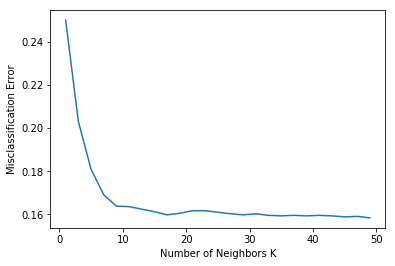

the misclassification error for each k value is :  [0.25  0.203 0.181 0.169 0.164 0.164 0.162 0.161 0.16  0.16  0.162 0.162
 0.161 0.16  0.16  0.16  0.16  0.159 0.16  0.159 0.16  0.159 0.159 0.159
 0.158]


In [20]:
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [21]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs = -1)
knn_optimal.fit(X_train, y_train)
pred = knn_optimal.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 49 is 84.277778%
